# Image-to-Image Translation with cGAN (pix2pix)

This notebook implements the pix2pix model using PyTorch for translating images from one domain to another. We will use the 'facades' dataset as an example, translating architectural labels into photorealistic images.

### 1. Setup and Imports
First, we'll import all the necessary libraries. We'll use `torch` and `torchvision` for building the model and handling data, `PIL` for image manipulation, `matplotlib` for plotting, and `numpy`. We also set up the device to use a GPU if one is available.

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [27]:
# Set device to GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [28]:
root_dir = 'Data/facades' 

class FacadesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.files = sorted(glob.glob(os.path.join(root_dir, split) + "/*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Split image into input and target
        w, h = image.size
        w2 = w // 2
        input_image = image.crop((0, 0, w2, h))
        target_image = image.crop((w2, 0, w, h))

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
            
        return input_image, target_image

IMG_SIZE = 256
# Define transformations
# Resize to 286x286, then random crop to 256x256
transform = T.Compose([
    T.Resize((286, 286), T.InterpolationMode.BICUBIC),
    T.RandomCrop(IMG_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = FacadesDataset(root_dir=root_dir, split='train', transform=transform)

test_dataset = FacadesDataset(root_dir=root_dir, split='val', transform=transform) 

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [29]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False) if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        # Encoder (Downsampling)
        self.down1 = UNetBlock(in_channels, 64, down=True, act="leaky", use_dropout=False)
        self.down2 = UNetBlock(64, 128, down=True, act="leaky", use_dropout=False)
        self.down3 = UNetBlock(128, 256, down=True, act="leaky", use_dropout=False)
        self.down4 = UNetBlock(256, 512, down=True, act="leaky", use_dropout=False)
        self.down5 = UNetBlock(512, 512, down=True, act="leaky", use_dropout=False)
        self.down6 = UNetBlock(512, 512, down=True, act="leaky", use_dropout=False)
        self.down7 = UNetBlock(512, 512, down=True, act="leaky", use_dropout=False)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU()
        )

        # Decoder (Upsampling) with skip connections
        self.up1 = UNetBlock(512, 512, down=False, act="relu", use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, act="relu", use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, act="relu", use_dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False, act="relu", use_dropout=False)
        self.up5 = UNetBlock(1024, 256, down=False, act="relu", use_dropout=False)
        self.up6 = UNetBlock(512, 128, down=False, act="relu", use_dropout=False)
        self.up7 = UNetBlock(256, 64, down=False, act="relu", use_dropout=False)
        
        # Final layer
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        bottleneck = self.bottleneck(d7)
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        return self.final_up(torch.cat([u7, d1], 1))

In [30]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        # Input is a concatenation of input_image and target_image, so in_channels*2
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.conv1 = ConvBlock(64, 128, stride=2)
        self.conv2 = ConvBlock(128, 256, stride=2)
        self.conv3 = ConvBlock(256, 512, stride=1) # Stride is 1 for the last conv block
        self.final = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.final(x)

In [31]:
# Hyperparameters
LEARNING_RATE = 2e-4
BETA1 = 0.5
L1_LAMBDA = 100
EPOCHS = 30 # Using a few more epochs for better results

# Model Initialization
gen = Generator().to(device)
disc = Discriminator().to(device)

# Optimizers
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

# Loss Functions
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

In [34]:
from tqdm import tqdm # For a nice progress bar

gen.train()
disc.train()

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    loop = tqdm(train_loader, leave=True)
    for idx, (input_img, target_img) in enumerate(loop):
        input_img, target_img = input_img.to(device), target_img.to(device)

        # --- Train Discriminator ---
        fake_img = gen(input_img)
        D_real_pred = disc(input_img, target_img)
        D_real_loss = bce_loss(D_real_pred, torch.ones_like(D_real_pred))
        D_fake_pred = disc(input_img, fake_img.detach())
        D_fake_loss = bce_loss(D_fake_pred, torch.zeros_like(D_fake_pred))
        D_loss = (D_real_loss + D_fake_loss) / 2
        
        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()
        
        # --- Train Generator ---
        D_fake_pred = disc(input_img, fake_img)
        G_adv_loss = bce_loss(D_fake_pred, torch.ones_like(D_fake_pred))
        G_l1_loss = l1_loss(fake_img, target_img) * L1_LAMBDA
        G_loss = G_adv_loss + G_l1_loss
        
        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()

        if idx % 200 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real_pred).mean().item(),
                D_fake=torch.sigmoid(D_fake_pred).mean().item(),
                G_loss=G_loss.item()
            )


--- Epoch 1/30 ---


100%|██████████| 400/400 [00:14<00:00, 27.85it/s, D_fake=0.161, D_real=0.82, G_loss=50.1] 



--- Epoch 2/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.67it/s, D_fake=0.0804, D_real=0.988, G_loss=38.1]



--- Epoch 3/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.64it/s, D_fake=0.00265, D_real=0.996, G_loss=40.4]



--- Epoch 4/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.64it/s, D_fake=0.00123, D_real=0.992, G_loss=37.4]



--- Epoch 5/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.65it/s, D_fake=0.0024, D_real=0.998, G_loss=41.7]



--- Epoch 6/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.66it/s, D_fake=0.000774, D_real=0.996, G_loss=48.9]



--- Epoch 7/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.66it/s, D_fake=0.0437, D_real=0.982, G_loss=43.8]



--- Epoch 8/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.64it/s, D_fake=0.0995, D_real=0.659, G_loss=42.2]



--- Epoch 9/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.59it/s, D_fake=0.453, D_real=0.521, G_loss=38]



--- Epoch 10/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.61it/s, D_fake=0.0998, D_real=0.931, G_loss=46.8]



--- Epoch 11/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.0365, D_real=0.991, G_loss=51.3]



--- Epoch 12/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.0544, D_real=0.997, G_loss=41.2]



--- Epoch 13/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.59it/s, D_fake=0.0746, D_real=0.922, G_loss=54.9]



--- Epoch 14/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.63it/s, D_fake=0.0133, D_real=0.996, G_loss=32.9]



--- Epoch 15/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.0333, D_real=0.774, G_loss=34.3]



--- Epoch 16/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.59it/s, D_fake=0.118, D_real=0.452, G_loss=41.8]  



--- Epoch 17/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.66it/s, D_fake=0.0271, D_real=0.975, G_loss=63.9]



--- Epoch 18/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.0257, D_real=0.961, G_loss=49.9] 



--- Epoch 19/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.64it/s, D_fake=0.00634, D_real=0.988, G_loss=41.7]



--- Epoch 20/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.58it/s, D_fake=0.00473, D_real=0.966, G_loss=41.6]



--- Epoch 21/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.59it/s, D_fake=0.0153, D_real=0.991, G_loss=57.7]



--- Epoch 22/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.0912, D_real=0.921, G_loss=46.6]



--- Epoch 23/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.58it/s, D_fake=0.0861, D_real=0.998, G_loss=69.8]



--- Epoch 24/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.65it/s, D_fake=0.0296, D_real=0.993, G_loss=71.9]



--- Epoch 25/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.63it/s, D_fake=0.489, D_real=0.915, G_loss=36.6] 



--- Epoch 26/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.65it/s, D_fake=0.013, D_real=0.971, G_loss=42]   



--- Epoch 27/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.64it/s, D_fake=0.0941, D_real=0.998, G_loss=56.3]



--- Epoch 28/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.62it/s, D_fake=0.151, D_real=0.994, G_loss=65.9]



--- Epoch 29/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.63it/s, D_fake=0.102, D_real=0.998, G_loss=45.1] 



--- Epoch 30/30 ---


100%|██████████| 400/400 [00:13<00:00, 28.61it/s, D_fake=0.0405, D_real=0.998, G_loss=46.9]


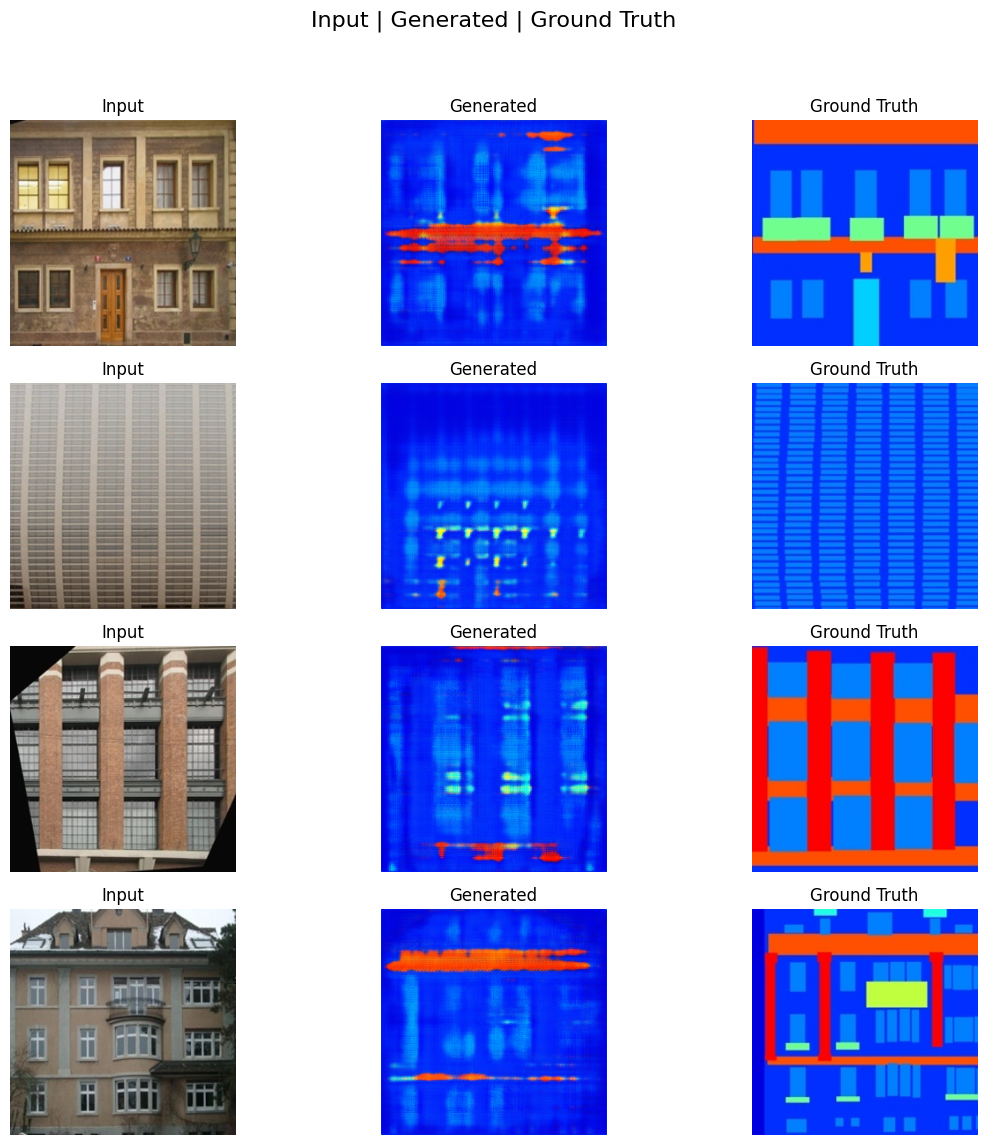

In [42]:
def show_images(test_loader, generator, num_images=4):
    generator.eval()
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        generated_images = generator(inputs)

    # Denormalize images from [-1, 1] to [0, 1] for plotting
    inputs = (inputs * 0.5 + 0.5).cpu()
    targets = (targets * 0.5 + 0.5).cpu()
    generated_images = (generated_images * 0.5 + 0.5).cpu()

    fig, axes = plt.subplots(num_images, 3, figsize=(12, 12))
    fig.suptitle('Input | Generated | Ground Truth', fontsize=16)
    
    for i in range(num_images):
        axes[i, 0].imshow(inputs[i].permute(1, 2, 0))
        axes[i, 0].set_title("Input")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(generated_images[i].permute(1, 2, 0))
        axes[i, 1].set_title("Generated")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(targets[i].permute(1, 2, 0))
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display results from the test set
show_images(test_loader, gen)